# Mécanisme d'attention
Dans ce notebook, nous allons explorer un problème de type *sequence-to-sequence*. Pour cela nous allons créer un jeu de donnée *jouet* (toy dataset) et l'analyser avec un réseau convolutif 1D. Nous comparerons les performances avant et après l'introduction d'une couche d'**attention**, ce qui nous permettra de comprendre la pertinence de ce mécanisme.

### imports python

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from io import open
import glob
import os
import matplotlib.pyplot as plt

## 1. Génération des données
On génère des sequences 1D contenant chacunes deux formes triangulaires et deux formes rectangulaires (step). La position et la hauteur de chacune des formes est choisie aléatoirement, la seule contrainte étant que les formes ne doivent pas se chevaucher.  
**L'objectif du notebook sera d'entrainer un modèle permettant de transformer un séquence de telle manière que les deux triangles et les deux rectangles fassent la même hauteur, respectivement.**  
[Source originale de l'exercice](https://fleuret.org/dlc/materials/dlc-handout-13-2-attention-mechanisms.pdf)

In [2]:
# hyperparamètres pour la génération
n_sequence = 5000 # nombres de séquences générées
n_points = 100 # nombre de points par séquence
width = 8 # largeur des triangles et step ajoutés dans les séquences

In [3]:
def make_shape(x, y, center, height, width=8, triangle=False):
    mask_up = (x <= center+width/2)
    mask_down = (x >= center-width/2)
    if triangle:
        y[mask_down & (x<=center)] = height * (x[mask_down & (x<=center)]-center+width/2) / 4
        y[mask_up & (x>center)] = height - height * (x[mask_up & (x>center)]-center) / 4
    else:
        y[mask_down & mask_up] = height
    return y

In [4]:
def difference_matrix(a):
    x = np.reshape(a, (len(a), 1))
    return x - x.transpose()

In [5]:
np.random.seed(42)

x_data = np.linspace(0, 100, 100)

s = 0
sequences_input = []
sequences_target_shape = [] # pour les parties 2 & 3
sequences_target_position = [] # pour la partie 4

while s < n_sequence:
    centers = np.sort(np.random.rand(4)*100) # génération aléatoire de la position des formes
    if centers.min()-width/2 < 0 or centers.max()+width/2 > 100:
        continue
    
    diff_matrix = np.abs(difference_matrix(centers))
    diag_mask = np.eye(diff_matrix.shape[0], diff_matrix.shape[1], dtype=bool)
    if diff_matrix[~diag_mask].min() >= width: # chevauchement ?
        s += 1
        heights = np.random.randint(2,29, 4) # génération aléatoire de la taille des formes
        triangle_idxs = np.random.choice(4, 2, replace=False) # choix aléatoire de la position des triangles
        mask_idx = np.zeros_like(heights).astype(bool)
        mask_idx[triangle_idxs] = True

        h_target_triangle = heights[mask_idx].mean() # cible = hauteur moyenne des triangles
        h_target_step = heights[~mask_idx].mean() # cible = hauteur moyenne des rectangle
        
        h_target_left = heights[:2].mean() # cible = hauteur moyenne des 2 formes les plus à gauche
        h_target_right = heights[2:].mean() # cible = hauteur moyenne des 2 formes les plus à droite

        seq = np.zeros_like(x_data)
        seq_target_shape = np.zeros_like(x_data)
        seq_target_position = np.zeros_like(x_data)
        for i, (c, h) in enumerate(zip(centers, heights)):
            if i in triangle_idxs:
                seq = make_shape(x_data, seq, c, h, triangle=True, width=width)
                seq_target_shape = make_shape(x_data, seq_target_shape, c, h_target_triangle, triangle=True, width=width)
                if i <2 :
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_left,
                                                     triangle=True, width=width)
                else:
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_right,
                                                     triangle=True, width=width)
            else:
                seq = make_shape(x_data, seq, c, h)
                seq_target_shape = make_shape(x_data, seq_target_shape, c, h_target_step)
                if i <2 :
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_left, width=width)
                else:
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_right, width=width)
                
        sequences_input.append(seq)
        sequences_target_shape.append(seq_target_shape)
        sequences_target_position.append(seq_target_position)
        
sequences_input = np.array(sequences_input).reshape(n_sequence, 1, 100)
sequences_target_shape = np.array(sequences_target_shape).reshape(n_sequence, 1, 100)
sequences_target_position = np.array(sequences_target_position).reshape(n_sequence, 1, 100)

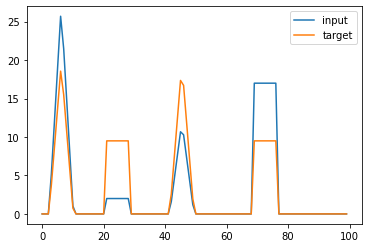

In [6]:
plt.plot(sequences_input[134,0], label='input')
plt.plot(sequences_target_shape[134,0], label='target')
plt.legend()

### Création des datasets pytorch

In [7]:
train_input, test_input, train_target, test_target = train_test_split(sequences_input,
                                                                      sequences_target_shape,
                                                                      test_size=0.25)

# Normalisation des données
mu, std = train_input.mean(), train_input.std()
train_input = (train_input-mu)/std
test_input = (test_input-mu)/std

# Conversion des tableaux numpy vers des tenseurs reconnus par pytorch :
train_input = torch.from_numpy(train_input).type(torch.FloatTensor)
train_target = torch.from_numpy(train_target).type(torch.FloatTensor)
train_data = TensorDataset(train_input, train_target)
print('dataset entrainement : ', train_data)

test_input = torch.from_numpy(test_input).type(torch.FloatTensor)
test_target = torch.from_numpy(test_target).type(torch.FloatTensor)
test_data = TensorDataset(test_input, test_target)
print('dataset entrainement : ', test_data)

dataset entrainement :  <torch.utils.data.dataset.TensorDataset object at 0x7f778fab2fb0>
dataset entrainement :  <torch.utils.data.dataset.TensorDataset object at 0x7f778fab2140>


## 2. Modèle sans mécanisme d'attention
**À faire** : Créer un modèle pytorch prenant en entrée une séquence et retournant en sortie une autre séquence, obtenue par l'application de 4 couches de convolution 1D, chacune composée de 64 convolutions de taille 5.  
On choisira un padding permettant de conserver la longeur originale des séquences et on appliquera une fonction d'activation ReLU après chaque convolution.

In [8]:
class Net_conv1d(nn.Module):
    def __init__(self):
        super(Net_conv1d, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=5, padding=2)            
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
model_conv1d = Net_conv1d()

### Entrainement

In [9]:
# Hyperparamètres
N_epochs = 50
learning_rate = 0.001
batch_size=50

n_iteration_per_epoch = len(train_input) // batch_size +1
n_test_loops = np.arange(0, N_epochs*n_iteration_per_epoch, n_iteration_per_epoch)

# Outil de chargement des données
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

**À faire** : choisir une fonction de coût pertinente pour le problème considéré.

In [10]:
loss_function = nn.MSELoss()

In [11]:
def train_loop(model, optimizer, loss_function, train_loader, test_loader, N_epochs):
    losses = []   
    val_losses = []
    for epoch in range(N_epochs):  # Boucle sur les époques    
        for inputs, targets in train_loader:
            #Propagation en avant
            preds = model(inputs) # Equivalent à model.forward(features)

            #Calcul du coût
            loss = loss_function(preds, targets)

            #on sauvegarde la loss pour affichage futur
            losses.append(loss.item())

            #Effacer les gradients précédents
            optimizer.zero_grad()

            #Calcul des gradients (rétro-propagation)
            loss.backward()

            #Mise à jour des poids : un pas de l'optimiseur
            optimizer.step()
        print('Epoque',epoch, 'loss', loss.item())
        
        val_losses.append(test_loop(model, test_loader))

    print('Entrainement terminé')
    
    return losses, val_losses

def test_loop(model, test_loader):
    with torch.no_grad():
        val_loss = []
        for inputs, targets in test_loader:
            #Propagation en avant
            preds = model(inputs)

            #Calcul du coût
            loss = loss_function(preds, targets)

            #on sauvegarde la loss pour affichage futur
            val_loss.append(loss.item())
        
    return np.array(val_loss).mean()

def draw_loss(losses, val_losses, n_test_loops):
    # Afficher l'évolution de la fonction de coût
    fig, axes = plt.subplots(figsize=(8,6))
    axes.plot(losses,'r-',lw=2,label='Fonction de cout')
    axes.plot(n_test_loops, val_losses,'b-',lw=2,label='Fonction de cout - validation')
    axes.set_xlabel('N iterations',fontsize=18)
    axes.set_ylabel('Cout',fontsize=18)
    plt.yscale('log')
    plt.legend(loc='upper right',fontsize=16)

In [12]:
optimizer = optim.Adam(model_conv1d.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_conv1d, optimizer, loss_function, train_dataloader, test_dataloader, N_epochs)

Epoque 0 loss 5.0848517417907715
Epoque 1 loss 3.682612419128418
Epoque 2 loss 4.0381364822387695
Epoque 3 loss 3.960096597671509
Epoque 4 loss 3.02070951461792
Epoque 5 loss 3.566535234451294
Epoque 6 loss 3.317253589630127
Epoque 7 loss 3.045945167541504
Epoque 8 loss 3.3022422790527344
Epoque 9 loss 3.3296523094177246
Epoque 10 loss 2.884350299835205
Epoque 11 loss 3.623730421066284
Epoque 12 loss 2.8877155780792236
Epoque 13 loss 3.493483543395996
Epoque 14 loss 3.1820831298828125
Epoque 15 loss 4.095551490783691
Epoque 16 loss 2.87199330329895
Epoque 17 loss 2.743731737136841
Epoque 18 loss 3.185123920440674
Epoque 19 loss 3.3642737865448
Epoque 20 loss 3.1891629695892334
Epoque 21 loss 3.26936674118042
Epoque 22 loss 3.019052267074585
Epoque 23 loss 3.3661508560180664
Epoque 24 loss 3.632188320159912
Epoque 25 loss 3.3570284843444824
Epoque 26 loss 3.312964916229248
Epoque 27 loss 3.105907917022705
Epoque 28 loss 3.2985551357269287
Epoque 29 loss 2.9527759552001953
Epoque 30 loss

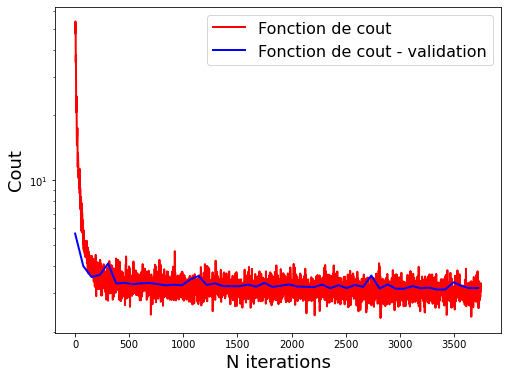

In [13]:
draw_loss(losses, val_losses, n_test_loops)

### Test

In [14]:
test_output_conv1d = model_conv1d(test_input)

In [15]:
print(f'Loss sur le dataset de test = {loss_function(test_output_conv1d, test_target):.3f}')

Loss sur le dataset de test = 3.181


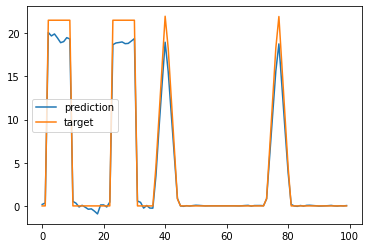

In [48]:
test_idx = 20

#plt.plot(test_input[test_idx,0].numpy()*std+mu, label='input')
plt.plot(test_output_conv1d[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target[test_idx,0].numpy(), label='target')
plt.legend()

## 3. Modèle avec couche d'attention

**À faire** : modifier le modèle défini plus haut en remplaçant la couche de convolution centrale par une couche d'attention.  
Rappel de la formule pour le mécanisme d'attention standard $$Y = \text{softmax} \left( QK^{T} \right) V $$  
On a les dimensions suivantes : $$ Q \in \mathcal{R}^{T\times D}, K \in \mathcal{R}^{T'\times D}, V \in \mathcal{R}^{T'\times D'} $$
où T (T') est la taille des séquences en entrée pour les *queries* (*keys*/*values*), et D (D') est la taille d'encodage des *queries*/*keys* (*values*). Le taille d'encodage des *queries* et ded *keys* doit correspondre, car les *queries* interrogent les *keys*.    

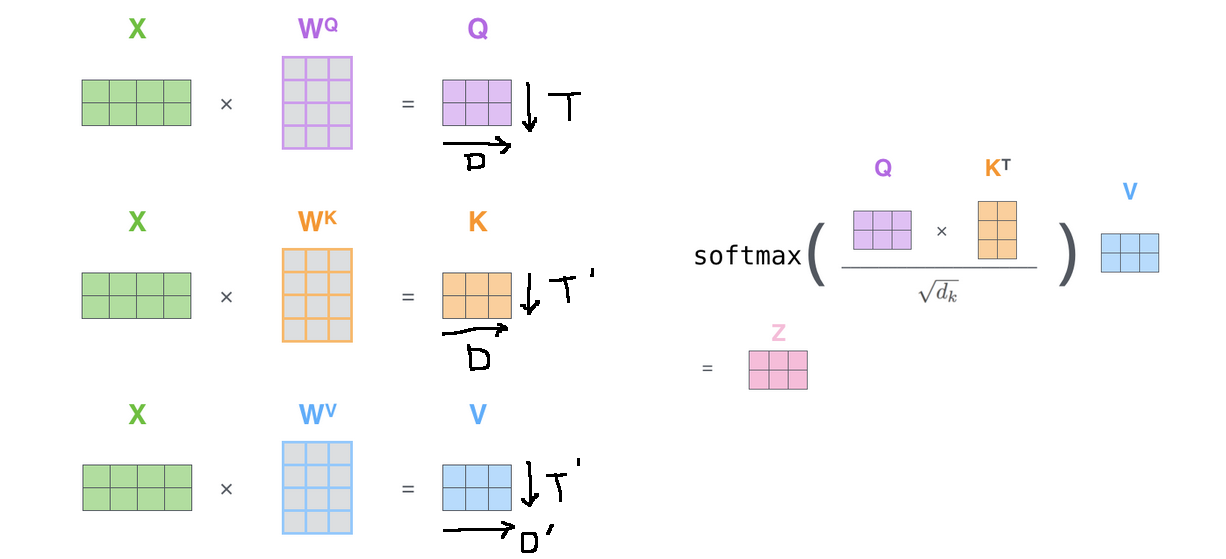

Dans notre problème présent, on compare une séquence à elle-même (T=T'=100). On appelle cela de la **self-attention**. On choisit également une taille d'encodage égale pour les *queries*, *keys* et *values* (D=D'=64).

In [41]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, key_dim):
        super().__init__()
        self.conv_Q = nn.Conv1d(in_dim, out_dim, kernel_size=1, bias=False)
        self.conv_K = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_V = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        
    def forward(self, x, return_attention=False):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        
        Q = Q.transpose(1,2)
        V = V.transpose(1,2)
        
        A = torch.matmul(Q, K).softmax(2)
        y = torch.matmul(A, V).transpose(1,2)
        if return_attention:
            return y, A
        else:
            return y

    
class Net_attention(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv_in = nn.Conv1d(in_channels, 64, kernel_size=5, padding=2)
        self.conv1 = nn.Conv1d(64, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=5, padding=2)
        self.conv_out = nn.Conv1d(64, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.att = SelfAttentionLayer(64, 64, 64)
        
    def forward(self, x, return_attention=False):
        x = self.relu( self.conv_in(x) )
        x = self.relu( self.conv1(x) )
        if return_attention:
            x, A = self.att(x, return_attention=True)
        else:
            x = self.att(x)
        x = self.relu( self.conv2(x) )
        x = self.conv_out(x)
        if return_attention:
            return x, A
        else:
            return x
    
model_attention = Net_attention()

### Entrainement

In [42]:
optimizer = optim.Adam(model_attention.parameters(), lr=learning_rate)

losses, val_losses = train_loop(model_attention, optimizer, loss_function, train_dataloader, test_dataloader, N_epochs)

Epoque 0 loss 4.8873796463012695
Epoque 1 loss 2.7479090690612793
Epoque 2 loss 2.0679242610931396
Epoque 3 loss 2.090010643005371
Epoque 4 loss 1.4907718896865845
Epoque 5 loss 1.408992886543274
Epoque 6 loss 1.6410043239593506
Epoque 7 loss 1.5945888757705688
Epoque 8 loss 1.189389705657959
Epoque 9 loss 1.7319458723068237
Epoque 10 loss 1.1912411451339722
Epoque 11 loss 1.1140698194503784
Epoque 12 loss 1.081955909729004
Epoque 13 loss 1.0792547464370728
Epoque 14 loss 0.9019931554794312
Epoque 15 loss 1.0483827590942383
Epoque 16 loss 1.1555793285369873
Epoque 17 loss 0.705795407295227
Epoque 18 loss 1.0193182229995728
Epoque 19 loss 0.8079178929328918
Epoque 20 loss 0.9637929797172546
Epoque 21 loss 1.1624904870986938
Epoque 22 loss 0.8163880705833435
Epoque 23 loss 1.5558815002441406
Epoque 24 loss 0.5673702359199524
Epoque 25 loss 0.8922967910766602
Epoque 26 loss 0.5515804886817932
Epoque 27 loss 0.5391509532928467
Epoque 28 loss 0.4146665036678314
Epoque 29 loss 0.261723548173

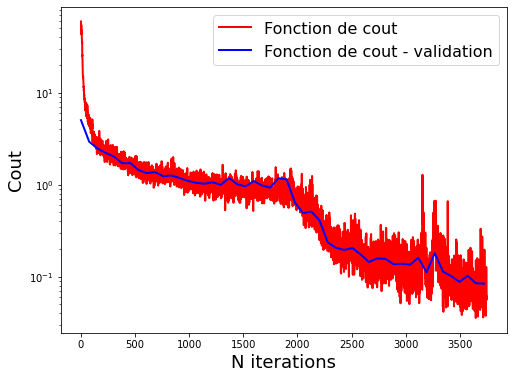

In [43]:
draw_loss(losses, val_losses, n_test_loops)

### Test

In [44]:
test_output_att = model_attention(test_input)

In [45]:
loss_function(test_output_att, test_target)

tensor(0.0843, grad_fn=<MseLossBackward0>)

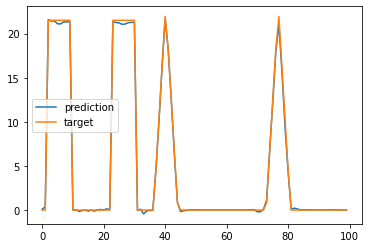

In [49]:
#plt.plot(test_input[10,0].numpy()*std+mu, label='input')
plt.plot(test_output_att[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target[test_idx,0].numpy(), label='target')
plt.legend()

### Visualisation de l'attention
On souhaite représenter la matrice d'attention (taille 100x100) pour une séquence de test.  
**À faire** : Modifier les classes `Net_attention` et `SelfAttentionLayer` afin qu'elles puissent retourner la matrice d'attention $$A = \text{softmax} \left( QK^{T} \right) $$ 

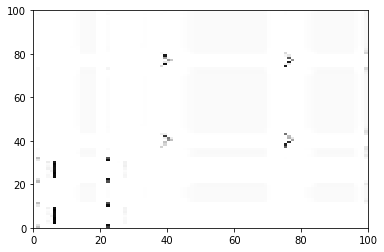

In [50]:
output, attention = model_attention(test_input[[test_idx]], return_attention=True)
plt.pcolor(attention.squeeze().detach().numpy(), cmap='gray_r')

## 4.Introduction au *positional encoding*
La couche d'attention définie au-dessus ne prend condidère aucunement la position des formes. On va introduire un nouvel objectif qui va dépendre de la position des formes afin d'illuster ici l'intérêt, et la nécessité, d'utiliser un *positional encoding* pour certaines tâches.

### Nouvelle tâche
Le nouvel objectif du réseau est de faire en sorte que les deux formes de gauche et les deux formes de droite aient la même hauteur, respectivement.

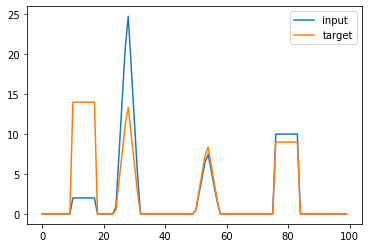

In [24]:
plt.plot(sequences_input[3,0], label='input')
plt.plot(sequences_target_position[3,0], label='target')
plt.legend()

On crée des nouveaux datasets et dataloaders avec les sequences cibles correspondant à la nouvelle tâche.

In [25]:
train_input_pos, test_input_pos, train_target_pos, test_target_pos = train_test_split(sequences_input,
                                                                      sequences_target_position,
                                                                      test_size=0.25)

# Normalisation des données
mu, std = train_input_pos.mean(), train_input_pos.std()
train_input_pos = (train_input_pos-mu)/std
test_input_pos = (test_input_pos-mu)/std

# Conversion des tableaux numpy vers des tenseurs reconnus par pytorch :
train_input_pos = torch.from_numpy(train_input_pos).type(torch.FloatTensor)
train_target_pos = torch.from_numpy(train_target_pos).type(torch.FloatTensor)
train_data_pos = TensorDataset(train_input_pos, train_target_pos)

test_input_pos = torch.from_numpy(test_input_pos).type(torch.FloatTensor)
test_target_pos = torch.from_numpy(test_target_pos).type(torch.FloatTensor)
test_data_pos = TensorDataset(test_input_pos, test_target_pos)

train_dataloader_pos = DataLoader(dataset=train_data_pos, batch_size=batch_size, shuffle=True)
test_dataloader_pos = DataLoader(dataset=test_data_pos, batch_size=batch_size, shuffle=False)

### Entrainement sans *positional encoding*

In [26]:
model_attention_noposition = Net_attention()

optimizer = optim.Adam(model_attention_noposition.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_attention_noposition, optimizer, loss_function, train_dataloader_pos, test_dataloader_pos, N_epochs)

Epoque 0 loss 5.076035022735596
Epoque 1 loss 2.9836156368255615
Epoque 2 loss 3.0041942596435547
Epoque 3 loss 3.0903866291046143
Epoque 4 loss 2.9027504920959473
Epoque 5 loss 2.4049596786499023
Epoque 6 loss 2.3508222103118896
Epoque 7 loss 2.275460720062256
Epoque 8 loss 2.2371530532836914
Epoque 9 loss 2.2450411319732666
Epoque 10 loss 1.7358890771865845
Epoque 11 loss 2.1852877140045166
Epoque 12 loss 2.2759008407592773
Epoque 13 loss 1.7447906732559204
Epoque 14 loss 2.2483348846435547
Epoque 15 loss 2.2529473304748535
Epoque 16 loss 2.410884141921997
Epoque 17 loss 2.1107699871063232
Epoque 18 loss 2.135122537612915
Epoque 19 loss 2.105001211166382
Epoque 20 loss 2.4514739513397217
Epoque 21 loss 2.2735085487365723
Epoque 22 loss 2.5226328372955322
Epoque 23 loss 2.0031027793884277
Epoque 24 loss 2.4198358058929443
Epoque 25 loss 2.0251002311706543
Epoque 26 loss 2.4352989196777344
Epoque 27 loss 1.9443227052688599
Epoque 28 loss 1.9491816759109497
Epoque 29 loss 2.453683376312

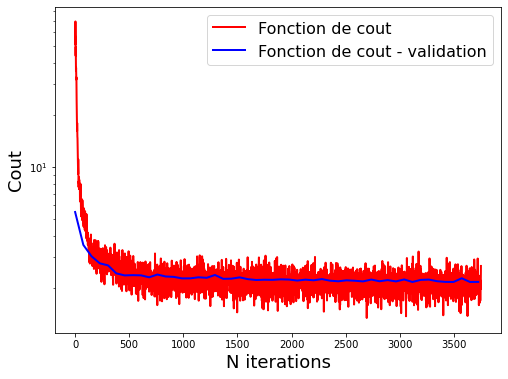

In [27]:
draw_loss(losses, val_losses, n_test_loops)

In [28]:
test_output_att_nopos = model_attention_noposition(test_input_pos)

In [29]:
loss_function(test_output_att_nopos, test_target_pos)

tensor(2.1578, grad_fn=<MseLossBackward0>)

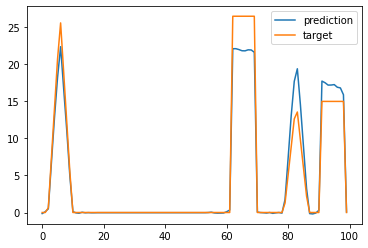

In [30]:
test_idx = 15

#plt.plot(test_input_pos[test_idx,0].numpy()*std+mu, label='input')
plt.plot(test_output_att_nopos[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target_pos[test_idx,0].numpy(), label='target')
plt.legend()

### Entrainement avec *positional encoding*
On va encoder en binaire la position de chaque point des séquences, puis concaténer cet encodage avec nos inputs.

In [31]:
def binary_positional_encoder(len_seq):
    c = np.ceil(np.log(len_seq) / np.log(2.0))
    o = 2**torch.arange(c).unsqueeze(1)
    pe = (torch.arange(len_seq).unsqueeze(0).div(o, rounding_mode = 'floor')) % 2
    return pe

**À faire** : créer le *positional encoding* correspondant aux séquences dans notre jeu de données.

In [32]:
pos_encoding = binary_positional_encoder(train_input_pos.shape[-1])

**À faire** : modifier les données d'entrainement et de test en concaténant chaque séquence d'input avec le *positional encoding* (même encodage pour toutes les séquences).  
Au final, pour un échantillon, on veux 8 canaux : 1 pour la séquence à proprement parler, et 7 additionels contenant le *positional encoding*.  
Au niveau des dimensions , on cherche à voir un tenseur de taille (N, 8, 100) suite à la concaténation, plutôt que (N, 1, 100) avant.

In [33]:
train_input_pe = torch.cat((train_input_pos, pos_encoding.expand(train_input_pos.shape[0],-1,-1)), dim=1)
test_input_pe = torch.cat((test_input_pos, pos_encoding.expand(test_input_pos.shape[0],-1,-1)), dim=1)

In [34]:
train_input_pe.shape

torch.Size([3750, 8, 100])

In [35]:
train_data_pos = TensorDataset(train_input_pe, train_target_pos)

test_data_pos = TensorDataset(test_input_pe, test_target_pos)

train_dataloader_pos = DataLoader(dataset=train_data_pos, batch_size=batch_size, shuffle=True)
test_dataloader_pos = DataLoader(dataset=test_data_pos, batch_size=batch_size, shuffle=False)

In [36]:
model_attention_pe = Net_attention(in_channels=8)
optimizer = optim.Adam(model_attention_pe.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_attention_pe, optimizer, loss_function, train_dataloader_pos, test_dataloader_pos, N_epochs)

Epoque 0 loss 6.40133810043335
Epoque 1 loss 5.559590816497803
Epoque 2 loss 3.194471836090088
Epoque 3 loss 3.5156946182250977
Epoque 4 loss 2.701951265335083
Epoque 5 loss 2.472219944000244
Epoque 6 loss 2.5117268562316895
Epoque 7 loss 2.567951202392578
Epoque 8 loss 2.261059522628784
Epoque 9 loss 1.8082633018493652
Epoque 10 loss 1.4422615766525269
Epoque 11 loss 1.8542070388793945
Epoque 12 loss 1.699633240699768
Epoque 13 loss 1.6776673793792725
Epoque 14 loss 1.9202462434768677
Epoque 15 loss 2.010451316833496
Epoque 16 loss 1.4003146886825562
Epoque 17 loss 1.4785034656524658
Epoque 18 loss 1.4861241579055786
Epoque 19 loss 1.3418909311294556
Epoque 20 loss 1.4285423755645752
Epoque 21 loss 1.490142822265625
Epoque 22 loss 1.060781717300415
Epoque 23 loss 1.0188724994659424
Epoque 24 loss 1.194225788116455
Epoque 25 loss 1.2138890027999878
Epoque 26 loss 1.2218595743179321
Epoque 27 loss 1.4341586828231812
Epoque 28 loss 1.112904667854309
Epoque 29 loss 0.9055446982383728
Epoq

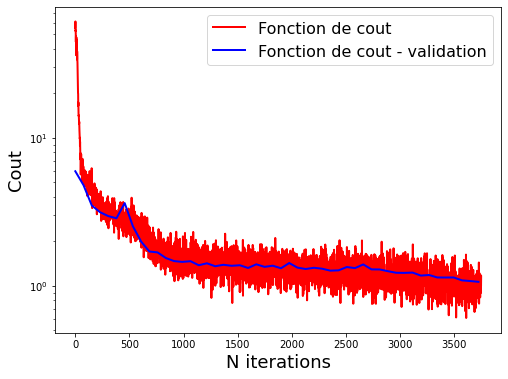

In [37]:
draw_loss(losses, val_losses, n_test_loops)

In [38]:
test_output_att_pos = model_attention_pe(test_input_pe)

In [39]:
loss_function(test_output_att_pos, test_target_pos)

tensor(1.0641, grad_fn=<MseLossBackward0>)

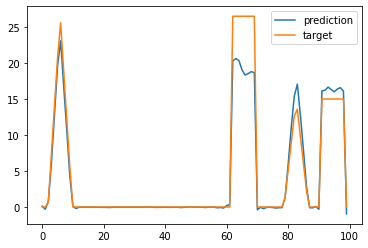

In [40]:
#plt.plot(test_input[10,0].numpy()*std+mu, label='input')
plt.plot(test_output_att_pos[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target_pos[test_idx,0].numpy(), label='target')
plt.legend()